In [2244]:
## imports
import sys, os, random, re, glob, copy
import pprint as pp
#from functools import reduce

In [2245]:
#!pip3 install 'pyLDAvis>3,<3.4'

In [2246]:
#!pip3 install -U plotly
#!pip3 install -U seaborn
#!pip3 install -U adjustText

In [2247]:
## NBConvert のために
#!pip install -U nbconvert
#!pip install -U pyppeteer

In [2248]:
## LDA の基本設定

## documents のencoding でLDA を使うか
use_LDA     = True

## topic 数の指定: topic 数は用語分類が目的であれば，分野数ぐらいが最適．
n_topics    = 7

## doc, term の設定
doc_type    = 'word'      # 変更不可
term_size   = 'character' # 変更不可
term_types  = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'skippy4gram' ]  
term_type   = term_types[-3]
print(f"term_type to use: {term_type}")

## doc の最大長と最小長
discard_too_long  = True
max_doc_length    = 13 # effective if discard_too_long is True
discard_too_short = True
min_doc_length    =  3 # effective if discard_too_short is True

## Raw term の濾過: unigram から除外する
remove_highly_frequent_unigrams = False
cutoff_rate = 0.001 # discard the most frequest terms by <rate>

## カタカナを含む語の除外
discard_kana_overloaded = True
kana_tolerance          = 0.5

## n-gram を包括 (n-gram が (n-1)を真に含む) 型にするかどうか
## 包括型にしないと，n が大きくなった時にエンコードされない事例が生じる
ngram_is_inclusive = True

## skippy n-gram の記号
gap_mark = "…"

## skippy n-gram が結びつく最長の gram数: bigram と trigram で共有
max_gap_val = round(max_doc_length * 0.75)
print(f"skippy n-gram max_gap: {max_gap_val}")

## DTM のterm 濾過の設定
minfreq = 2 # 最低頻度
abuse_threshold = 0.01 # 値が小さい方が濾過力が大きい．0.1 は十分に大きい．


term_type to use: skippy2gram
skippy n-gram max_gap: 10


In [2249]:
### FastText 用の設定

## documents のencoding でFastText を使うか: LDA と併用可能
use_FastText = True

## window の大きさ（LDA のn_topics に相当）の指定
vector_size_val = n_topics

## FastText のパラメター window の値: skippy n-gram のn に相当
n_for_ngrams = 5
window_size = n_for_ngrams

In [2250]:
## 設定の確認
assert use_LDA or use_FastText

In [2251]:
### tSNE の設定

## topic の tSNE 用の設定
top_perplexity_reduct_rate = 0.5
print(f"top_perplexity_rate: {top_perplexity_reduct_rate}")

## doc の tSNE 用の設定
doc_perplexity_reduct_rate1 = 0.7 # topic数に依存する場合
doc_perplexity_reduct_rate2 = 0.33 # doc数に依存する場合

## doc_perplexity を n_topics に基づいて決めるか事例数に基づいて決めるかの選択
doc_perplexity_depends_on_n_topics = False
if doc_perplexity_depends_on_n_topics:
    doc_perplexity_reduc_rate = doc_perplexity_reduct_rate1
else:
    doc_perplexity_reduct_rate = doc_perplexity_reduct_rate2
print(f"doc_perplexity_reduct_rate: {doc_perplexity_reduct_rate}")

top_perplexity_rate: 0.5
doc_perplexity_reduct_rate: 0.33


使用データの設定

In [2252]:
## 一般設定
verbose           = False
save_data         = False
save_df_sampled   = False

## 分野の設定
domain_mapping = { 0: 'medical', 1: 'mce',
                  2: 'economic', 3: 'juridical', 4: 'publishing', 5: 'cooking', 6: 'other' }

domain_names = domain_mapping.values()

## juridical のデータ拡張をするか
add_juridic2 = True

## 誤用を取り込むか
include_aberrated = True # aberrated medical terms を含めるか

## 解析対象分野の選別
domain_selection = { 'medical'    : True,
                     'mce'        : False,
                     'economic'   : False,
                     'juridical'  : True,
                     'publishing' : False,
                     'cooking'    : True
                     }

## 列名の定義
target_vars = ['word']
target_vars.extend(domain_selection.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k: v for k, v in domain_selection.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## 注目する分野の指定
target_domain = 'medical'
try:
    assert target_domain in selected_domains.keys()
except AssertionError:
    print(f"target {target_domain} not in selected domains")

## 分野毎の事例数の均衡化
if len(selected_domains) > 1:
    balanced = True
else:
    balanced = False
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking']
selected domains: ['medical', 'juridical', 'cooking']
domain balancing: True


In [2253]:
## colormap の定義: N.B. Plotly go.Scatter_3D(..) では有効でない
colors =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'powderblue', 'gray' ]
colormap = { k : colors[k] for k, v in domain_mapping.items() if v in selected_domains.keys() }
if verbose:
    print(colormap)
for k, v in colormap.items():
    print(f"分野: {k} {domain_mapping[k]}".ljust(18) + " => ".rjust(-10) + f"色: {v}")

分野: 0 medical      => 色: deeppink
分野: 3 juridical    => 色: green
分野: 5 cooking      => 色: powderblue


ファイルを読み込んでデータ構築

In [2254]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(sorted(dirs))

In [2255]:
## list up files in target directory 
targetdir = "terms-source" # can be changed
files = sorted(list(wd.glob(f"{targetdir}/terms*.xlsx")))
#
print(f"\n{targetdir} contains {len(files)} files to process")
pp.pprint(files)


terms-source contains 8 files to process
[PosixPath('terms-source/terms-cooking-v1a.xlsx'),
 PosixPath('terms-source/terms-economic-v1b.xlsx'),
 PosixPath('terms-source/terms-juridical-v1a2.xlsx'),
 PosixPath('terms-source/terms-juridical-v1b2.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-errors-v1a.xlsx'),
 PosixPath('terms-source/terms-medical-v1b.xlsx'),
 PosixPath('terms-source/terms-publishing-v1b.xlsx')]


In [2256]:
## 本来のファイルの処理
files_core = [ fn for fn in files if not "juridical-v1b2" in str(fn) and not "errors-v" in str(fn) ]
files_core

[PosixPath('terms-source/terms-cooking-v1a.xlsx'),
 PosixPath('terms-source/terms-economic-v1b.xlsx'),
 PosixPath('terms-source/terms-juridical-v1a2.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-v1b.xlsx'),
 PosixPath('terms-source/terms-publishing-v1b.xlsx')]

In [2257]:
## 必要に応じて次を実行
#!pip install -U openpyxl

In [2258]:
## ファイルの読み込み
import numpy as np
import pandas as pd

raw_dfs = [ ]
for file in files_core:
    ## 出版用語のsampled = 1 の場合のみ選別
    if "publishing" in str(file):
        d = pd.read_excel(file) # requires openpyxl to be installed
        d = d[d['local.id'] != None]
        d = d[d['unique'] == 1] # 重複出現する語を除外
        d = d[d['sampled'] == 1]
        raw_dfs.append(d)
    else:
        d = pd.read_excel(file)
        d = d[d['local.id'] != None]
        d = d[d['unique'] == 1] # 重複出現する語を除外
        raw_dfs.append(d) # requires openpyxl to be installed
##
raw_dfs

[      local.id        word  unique  medical  mce  economic  juridical  \
 0          1.0      8番らーめん     1.0      0.0  0.0       0.0        0.0   
 1          2.0      ABCスープ     1.0      0.0  0.0       0.0        0.0   
 2          3.0        Aランチ     1.0      0.0  0.0       0.0        0.0   
 3          4.0      BTSサラダ     1.0      0.0  0.0       0.0        0.0   
 4          5.0  SIOコンコーンカツ     1.0      0.0  0.0       0.0        0.0   
 ...        ...         ...     ...      ...  ...       ...        ...   
 4922    4987.0       黒豆サラダ     1.0      0.0  0.0       0.0        0.0   
 4923    4988.0     黒部ダムカレー     1.0      0.0  0.0       0.0        0.0   
 4924    4989.0         龍眼卵     1.0      0.0  0.0       0.0        0.0   
 4925    4990.0      龍馬ギョーザ     1.0      0.0  0.0       0.0        0.0   
 4926    4991.0       龍馬タタキ     1.0      0.0  0.0       0.0        0.0   
 
       publishing  cooking  valid     rid  subsampled  note  
 0            0.0      1.0    1.0  4864.0       

In [2259]:
## DataFrame 構築
check = False
dfs = [ ]
for dfx in raw_dfs:
    if check:
        print(dfx)
    try:
        data = dfx[target_vars]
    except KeyError:
        data.loc[:,'aberrated'] = 0
    if check:
        print(data)
    dfs.append(data)
## 統合
df0 = pd.concat(dfs)
if check:
    df0

In [2260]:
## 追加ファイルの処理
remaining_files = [ file for file in files if not file in files_core ]
print(f"Remaining files: {remaining_files}")

Remaining files: [PosixPath('terms-source/terms-juridical-v1b2.xlsx'), PosixPath('terms-source/terms-medical-errors-v1a.xlsx')]


In [2261]:
## juridical2 の追加
if add_juridic2:
    #juridic2_file = filter(lambda x: re.match("-juridical", x), remaining_files)
    juridic2_file = [ fn for fn in remaining_files if "-juridic" in str(fn) ][0]
    print(juridic2_file)
    raw_juridic2 = pd.read_excel(juridic2_file)
    ## juridical の sampled = 1 で unique = 1 の事例のみを選別
    raw_juridic2 = raw_juridic2[ (raw_juridic2['sampled'] == 1) & (raw_juridic2['unique'] == 1) ]
    raw_juridic2 = raw_juridic2[ target_vars ]
    df0 = pd.concat([df0, raw_juridic2])
#
df0

terms-source/terms-juridical-v1b2.xlsx


,word,medical,mce,economic,juridical,publishing,cooking
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0
2,Aランチ,0.0,0.0,0.0,0.0,0.0,1.0
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
870,訴訟指揮,0.0,0.0,0.0,1.0,0.0,0.0
871,上告審,0.0,0.0,0.0,1.0,0.0,0.0
874,制限行為能力者,0.0,0.0,0.0,1.0,0.0,0.0
875,被控訴人,0.0,0.0,0.0,1.0,0.0,0.0


In [2262]:
## aberrated medical terms の追加
if include_aberrated:
    ## 初期設定
    df0['aberrated'] = 0
    #
    med_error_fn = [ fn for fn in remaining_files if "-errors" in str(fn) ][0]
    raw_errors = pd.read_excel(med_error_fn)
    ## med errors の aberrated = 1 の事例のみを選別
    #raw_errors = raw_errors[raw_errors['aberrated'] == 1 & raw_errors['word'] != None ]
    raw_errors = raw_errors[ raw_errors['aberrated'] == 1 ]
    raw_errors = raw_errors[target_vars]
    n_sample_errors = round( 0.3 * len(raw_errors))
    med_errors = raw_errors.sample(n_sample_errors)
    med_errors['aberrated'] = 1
    med_errors['domain_id'] = 0
    #
    df0 = pd.concat([df0, med_errors])
#
df0

,word,medical,mce,economic,juridical,publishing,cooking,aberrated,domain_id
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN
2,Aランチ,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN
...,...,...,...,...,...,...,...,...,...
529,壊疽帯状疱疹,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1114,血性痔核,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2780,適応行,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1686,後部腫瘍,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0


Filtering

In [2263]:
## 長過ぎる語と短過ぎる語を除外
original_len = len(df0)
if discard_too_long:
    df0 = df0[ [ True if len(str(x)) <= max_doc_length else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they are longer than {max_doc_length}")

if discard_too_short:
    df0 = df0[ [ True if len(str(x)) >= min_doc_length else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they are shorter than {min_doc_length}")

12774: 111 cases are removed because they are longer than 13
11806: 1079 cases are removed because they are shorter than 3


In [2264]:
## カタカナ/ひらがなを多く含む語の除外
def katakana_count(s: str):
    import regex
    p = regex.compile(r'\p{Script=Katakana}')
    return len(p.findall(s))

def hiragana_count(s: str):
    import regex
    p = regex.compile(r'\p{Script=Hiragana}')
    return len(p.findall(s))
#
original_len = len(df0)    
if discard_kana_overloaded:
    ## katakana
    df0 = df0[ [ True if katakana_count(str(x))/len(str(x)) <= kana_tolerance else False for x in df0[doc_type] ] ]
    ## hiragana
    df0 = df0[ [ True if hiragana_count(str(x))/len(str(x)) <= kana_tolerance else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they contain too many kana characters")

8205: 3601 cases are removed because they contain too many kana characters


In [2265]:
## 色分けの為の domain_id を定義
check = False
domain_id_list = [ ]
print(f"Mapping domian names to colors")
for i, row in df0.iterrows():
    if check:
        print(f"{row['medical']}, {row['mce']}, {row['economic']}, {row['juridical']}, {row['publishing']}, {row['cooking']}" )
    if   row['medical']    == 1: domain_id_list.append(0)
    elif row['mce']        == 1: domain_id_list.append(1)
    elif row['economic']   == 1: domain_id_list.append(2)
    elif row['juridical']  == 1: domain_id_list.append(3)
    elif row['publishing'] == 1: domain_id_list.append(4)
    elif row['cooking']    == 1: domain_id_list.append(5)
    else:                        domain_id_list.append(6)
#
df0['domain_id'] = domain_id_list

## domain の事例数の確認
df0['domain_id'].value_counts().sort_index()

Mapping domian names to colors


domain_id
0    4193
1     690
2     357
3     491
4     789
5    1685
Name: count, dtype: int64

In [2266]:
## 重複の削除
df0 = df0.drop_duplicates(subset = [doc_type], keep = 'first')

In [2267]:
## 分野の事例数の確認
print(f"Effective domains")
S = [ ]
for domain_name in selected_domains.keys():
    print(f"domain_name: {domain_name}")
    S.append(df0[df0[domain_name] == 1])
#
df0 = pd.concat(S, axis = 0)
df0

Effective domains
domain_name: medical
domain_name: juridical
domain_name: cooking


,word,medical,mce,economic,juridical,publishing,cooking,aberrated,domain_id
0,1型糖尿病,1.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2型糖尿病,1.0,0.0,0.0,0.0,0.0,0.0,0,0
2,HIV感染,1.0,0.0,0.0,0.0,0.0,0.0,0,0
4,アキレス腱断裂手術,1.0,0.0,0.0,0.0,0.0,0.0,0,0
8,アミノ酸欠乏性貧血,1.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
4918,黒糖クッキー,0.0,0.0,0.0,0.0,0.0,1.0,0,5
4919,黒糖ケーキ,0.0,0.0,0.0,0.0,0.0,1.0,0,5
4920,黒胡麻きな粉,0.0,0.0,0.0,0.0,0.0,1.0,0,5
4924,龍眼卵,0.0,0.0,0.0,0.0,0.0,1.0,0,5


In [2268]:
## 分野指定の整合性の確認
var_names = [ 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking' ]
df0['checksum'] = df0[var_names].sum(axis = 1)

len(df0[df0['checksum'] == 0])
len(df0[df0['checksum'] > 1])

0

In [2269]:
## 混合のための割合を調整: 事例数を揃えるために復元抽出の設定にしているので
## 事例の重複が起きる
if balanced:
    domain_sample_size = 500
    # Medical
    if 'medical' in selected_domains.keys():
        med_sampled = df0[ df0['medical'] == 1 ].sample(domain_sample_size, replace = False)
    else:
        med_sampled = None
    # MCE
    if 'mce' in selected_domains.keys():
        mce_sampled = df0[ df0['mce'] == 1 ].sample(domain_sample_size, replace = False)
    else:
        mce_sampled = None
    # Juridical
    if 'juridical' in selected_domains.keys():
        jurid_sampled = df0[ df0['juridical'] == 1 ].sample(domain_sample_size, replace = True)
    else:
        jurid_sampled = None
    # Publishing
    if 'publishing' in selected_domains.keys():
        pub_sampled = df0[ df0['publishing'] == 1 ].sample(domain_sample_size, replace = True)
    else:
        pub_sampled = None
    # Cooking
    if 'cooking' in selected_domains.keys():
        cook_sampled = df0[ df0['cooking'] == 1 ].sample(domain_sample_size, replace = False)
    else:
        cook_sampled = None
    ## integration
    df0 = pd.concat([med_sampled, mce_sampled, jurid_sampled, pub_sampled, cook_sampled,
                 df0[df0['economic'] == 1]])

## domain の事例数の確認
df0['domain_id'].value_counts(sort = True).sort_index()

domain_id
0    500
3    500
5    500
Name: count, dtype: int64

In [2270]:
## 順序をランダマイズし df0 を df として再定義
import sklearn.utils
df = sklearn.utils.shuffle(df0)

In [2271]:
## 設定の確認
doc_type
df[['word', 'domain_id', 'checksum']]

,word,domain_id,checksum
379,永住許可,3,1.0
3157,天狗の麦飯,5,1.0
3597,柿の葉寿司,5,1.0
1412,応急入院,0,1.0
3386,弟子屈ラーメン,5,1.0
...,...,...,...
10,身元保証金,3,1.0
4784,鮎の石焼き,5,1.0
2783,腸炎後症候群,0,1.0
145,被疑者勾留,3,1.0


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_41758/459730398.py:12: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



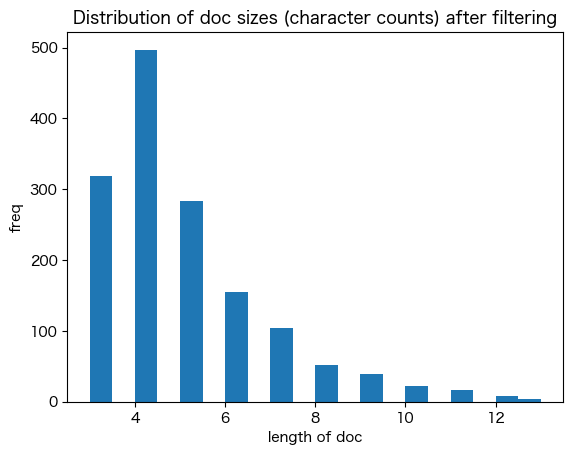

In [2272]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

d = [ len(x) for x in df[doc_type] ]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(d, bins = 20)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of doc sizes (character counts) after filtering")
fig.show()

DTM 構築

In [2273]:
## 共有される名称の定義
docs = df[doc_type]
docs

379        永住許可
3157      天狗の麦飯
3597      柿の葉寿司
1412       応急入院
3386    弟子屈ラーメン
         ...   
10        身元保証金
4784      鮎の石焼き
2783     腸炎後症候群
145       被疑者勾留
733         仲立人
Name: word, Length: 1500, dtype: object

In [2274]:
## 1gram 生成
unigrams = [ ]
check = False
for x in docs:
    if check:
        print(x)
    u = list(x)
    if len(u) > 0:
        unigrams.append(u)
#
random.sample(unigrams, 3)

[['煮', 'か', 'つ', '丼'], ['強', '行', '規', '定'], ['頬', '部', '圧', '挫', '傷']]

In [2275]:
## 名称の設定
df['1gram'] = unigrams
df

,word,medical,mce,economic,juridical,publishing,cooking,aberrated,domain_id,checksum,1gram
379,永住許可,0.0,0.0,0.0,1.0,0.0,0.0,0,3,1.0,"[永, 住, 許, 可]"
3157,天狗の麦飯,0.0,0.0,0.0,0.0,0.0,1.0,0,5,1.0,"[天, 狗, の, 麦, 飯]"
3597,柿の葉寿司,0.0,0.0,0.0,0.0,0.0,1.0,0,5,1.0,"[柿, の, 葉, 寿, 司]"
1412,応急入院,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,"[応, 急, 入, 院]"
3386,弟子屈ラーメン,0.0,0.0,0.0,0.0,0.0,1.0,0,5,1.0,"[弟, 子, 屈, ラ, ー, メ, ン]"
...,...,...,...,...,...,...,...,...,...,...,...
10,身元保証金,0.0,0.0,0.0,1.0,0.0,0.0,0,3,1.0,"[身, 元, 保, 証, 金]"
4784,鮎の石焼き,0.0,0.0,0.0,0.0,0.0,1.0,0,5,1.0,"[鮎, の, 石, 焼, き]"
2783,腸炎後症候群,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,"[腸, 炎, 後, 症, 候, 群]"
145,被疑者勾留,0.0,0.0,0.0,1.0,0.0,0.0,0,3,1.0,"[被, 疑, 者, 勾, 留]"


In [2276]:
## 1gram の頻度を取得
import collections
unigrams_all = [ ]
[ unigrams_all.extend(L) for L in df['1gram'] ]

unigram_freqs = collections.Counter(unigrams_all)
unigram_freqs.most_common(20)

[('の', 142),
 ('性', 137),
 ('ー', 107),
 ('き', 61),
 ('し', 54),
 ('腫', 51),
 ('傷', 50),
 ('炎', 49),
 ('権', 48),
 ('判', 46),
 ('症', 45),
 ('大', 44),
 ('焼', 44),
 ('ン', 41),
 ('瘍', 41),
 ('部', 41),
 ('血', 40),
 ('人', 38),
 ('骨', 37),
 ('者', 37)]

In [2277]:
## 高頻度 1gram フィルターの産物を確認
highly_frequents = sorted(unigram_freqs, reverse = True)[:round(cutoff_rate * len(df['1gram']))]
highly_frequents

['龍', '鼻']

高頻度文字 1-grams を df['1gram'] から除外

In [2278]:
## 高頻度 1-gram の除外
if remove_highly_frequent_unigrams:
    df['1gram'].apply(lambda x:
                     [ u for u in df['1gram'] if not u in highly_frequents ] )
    print(f"{len(highly_frequents)} unigrams were removed due to high frequency")
else:
    print(f"{len(highly_frequents)} unigrams were not removed")

2 unigrams were not removed


In [2279]:
## bigram 生成
n = 2
bigrams = [ ]
check = False
for doc in docs:
    if check: print(doc)
    size = len(doc)
    if size < n:
         bigrams.append([doc])
    else:
        L = [ ]
        for i in range(size - n + 1):
            x = doc[ i:i+n ]
            if check: print(x)
            if len(x) == n:
                L.append(x)
        if len(L) > 0:
            bigrams.append(L)

## 包括的 2gramの生成
if ngram_is_inclusive:
    for i, b in enumerate(bigrams):
        b.extend(unigrams[i])
#
random.sample(bigrams, 3)

[['耳介', '介裂', '裂創', '耳', '介', '裂', '創'],
 ['副乳', '乳部', '部瘍', '副', '乳', '部', '瘍'],
 ['離婚', '婚後', '後扶', '扶養', '離', '婚', '後', '扶', '養']]

In [2280]:
## 変数の追加
df['2gram'] = bigrams
if verbose:
    df

In [2281]:
## trigram 生成
check = False
n = 3
trigrams = [ ]
for doc in docs:
    if check: print(f"doc: {doc}")
    size = len(doc)
    if size < n:
        trigrams.append([doc]) 
    else:
        L = [ ]
        for i in range(size - n + 1):
            x = doc[ i:i+n ]
            if check: print(f"x: {x}")
            if len(x) == n:
                L.append(x)
        if check: print(f"L: {L}")
        #if len(L) > 0:
        trigrams.append(L)

## 包括的 3gramの生成
if ngram_is_inclusive:
    for i, t in enumerate(trigrams):
        t.extend(bigrams[i])
#
if verbose:
    random.sample(trigrams, 2)

In [2282]:
## 変数の追加
df['3gram'] = trigrams
if verbose:
    df

In [2283]:
## skippy 2grams の生成
import ngrams_skippy
skippy2grams = [ ngrams_skippy.gen_skippy2grams(x, missing_mark = gap_mark,
                                                   max_distance = max_gap_val,
                                                   minimize = False, check = False)
                for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy2grams):
        b2.extend(unigrams[i])
#
random.sample(skippy2grams, 2)

[['眼球', '眼…運', '眼…動', '球運', '球…動', '運動', '眼', '球', '運', '動'],
 ['吐下', '吐…血', '下血', '吐', '下', '血']]

In [2284]:
## 変数の追加
df['skippy2gram'] = skippy2grams
if verbose:
    df

In [2285]:
## skippy 3grams
skippy3grams = [ ngrams_skippy.gen_skippy3grams(x, missing_mark = gap_mark,
                                                max_distance = max_gap_val,
                                                minimize = False, check = False)
                for x in df[doc_type] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy3grams):
        t2.extend(skippy2grams[i])
#
if verbose:
    random.sample(skippy3grams, 2)

In [2286]:
## 変数の追加
df['skippy3gram'] = skippy3grams
if verbose:
    df

In [2287]:
## skippy 4grams
check = True
skippy4grams = [ ngrams_skippy.gen_skippy4grams(x, missing_mark = gap_mark,
                                                    max_distance = max_gap_val,
                                                    minimize = False, check = False)
                for x in df[doc_type] ]

## 包括的 skippy 4-grams の生成
if ngram_is_inclusive:
    for i, q2 in enumerate(skippy4grams):
        q2.extend(skippy3grams[i])
#
if verbose:
    random.sample(skippy4grams, 2)

In [2288]:
check = True
if check:
    pp.pprint(random.sample([ g for g in skippy4grams if max(map(len, g)) > 4 ], 2))

[['防護標章',
  '防護標…登',
  '防護標…録',
  '防護…章登',
  '防護…章…録',
  '防護…登録',
  '防…標…章登',
  '防…標章…録',
  '防…標…登録',
  '防…章…登録',
  '護標章登',
  '護標章…録',
  '護標…登録',
  '護…章…登録',
  '標章登録',
  '防護標',
  '防護…章',
  '防護…登',
  '防護…録',
  '防…標章',
  '防…標…登',
  '防…標…録',
  '防…章登',
  '防…章…録',
  '防…登録',
  '護標章',
  '護標…登',
  '護標…録',
  '護…章登',
  '護…章…録',
  '護…登録',
  '標章登',
  '標章…録',
  '標…登録',
  '章登録',
  '防護',
  '防…標',
  '防…章',
  '防…登',
  '防…録',
  '護標',
  '護…章',
  '護…登',
  '護…録',
  '標章',
  '標…登',
  '標…録',
  '章登',
  '章…録',
  '登録',
  '防',
  '護',
  '標',
  '章',
  '登',
  '録'],
 ['未成年後',
  '未成年…見',
  '未成年…監',
  '未成年…督',
  '未成年…人',
  '未成…後見',
  '未成…後…監',
  '未成…後…督',
  '未成…後…人',
  '未成…見監',
  '未成…見…督',
  '未成…見…人',
  '未成…監督',
  '未成…監…人',
  '未成…督人',
  '未…年…後見',
  '未…年後…監',
  '未…年後…督',
  '未…年後…人',
  '未…年…見監',
  '未…年…見…督',
  '未…年…見…人',
  '未…年…監督',
  '未…年…監…人',
  '未…年…督人',
  '未…後…見監',
  '未…後見…督',
  '未…後見…人',
  '未…後…監督',
  '未…後…監…人',
  '未…後…督人',
  '未…見…監督',
  '未…見監…人',
  '未…見…督人',
  '未…監…督人',
  '成年後見',
  '成年後…監',
  '成年後…督',
  '成年後…人',
  

In [2289]:
## 変数の追加
df['skippy4gram'] = skippy4grams
if verbose:
    df

In [2290]:
## 使ったデータの保存
if save_data:
    import datetime as dt
    ct = dt.datetime.now()
    ## Pandas で .csv として
    output_fn1 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".csv"
    print(f"saving data to {output_fn1}")
    import pandas as pd
    df.to_csv(output_fn1)
    ## pickle.dump(..)で
    output_fn2 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".p"
    import pickle
    print(f"saving data to {output_fn2}")
    with open(output_fn2, "wb") as f:
        pickle.dump(df, f)

In [2291]:
## 解析対象の確認
## aberrated == 1 は訓練事例に含めない
bots = df[df['aberrated'] == 0][term_type]
bots

379               [永住, 永…許, 永…可, 住許, 住…可, 許可, 永, 住, 許, 可]
3157    [天狗, 天…の, 天…麦, 天…飯, 狗の, 狗…麦, 狗…飯, の麦, の…飯, 麦飯,...
3597    [柿の, 柿…葉, 柿…寿, 柿…司, の葉, の…寿, の…司, 葉寿, 葉…司, 寿司,...
1412              [応急, 応…入, 応…院, 急入, 急…院, 入院, 応, 急, 入, 院]
3386    [弟子, 弟…屈, 弟…ラ, 弟…ー, 弟…メ, 弟…ン, 子屈, 子…ラ, 子…ー, 子…...
                              ...                        
10      [身元, 身…保, 身…証, 身…金, 元保, 元…証, 元…金, 保証, 保…金, 証金,...
4784    [鮎の, 鮎…石, 鮎…焼, 鮎…き, の石, の…焼, の…き, 石焼, 石…き, 焼き,...
2783    [腸炎, 腸…後, 腸…症, 腸…候, 腸…群, 炎後, 炎…症, 炎…候, 炎…群, 後症...
145     [被疑, 被…者, 被…勾, 被…留, 疑者, 疑…勾, 疑…留, 者勾, 者…留, 勾留,...
733                                [仲立, 仲…人, 立人, 仲, 立, 人]
Name: skippy2gram, Length: 1402, dtype: object

In [2292]:
## stopwords を除外
stopwords = [ '腫瘍', '性', '炎', '血', '腫', '瘍', 'の' ]

remove_stopwords = False
if remove_stopwords:
    bows = [ [ x for x in bot if x not in stopwords ] for bot in bots ]
#
if verbose:
    random.sample(list(bots), 3)

LDA を実行

In [2293]:
## LDA 構築の基になる dictionary = document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<12409 unique tokens: ['住', '住…可', '住許', '可', '永']...>


In [2294]:
## 構造の確認
for k in random.sample(diction.keys(), 20):
    print(f"index: {k} ; term: {diction[k]}")

index: 5738 ; term: 包み
index: 7171 ; term: 債…簿
index: 1476 ; term: ウ…踊
index: 3121 ; term: 犬
index: 8210 ; term: 糀炒
index: 11760 ; term: 変…豆
index: 5579 ; term: 成年
index: 9064 ; term: 仮…性
index: 11353 ; term: 扶助
index: 10510 ; term: ほそ
index: 10501 ; term: の…バ
index: 7187 ; term: 美…干
index: 10209 ; term: チ…★
index: 7337 ; term: 買
index: 12325 ; term: 賀茂
index: 210 ; term: 腸…端
index: 8429 ; term: 認否
index: 3544 ; term: 鉄…丼
index: 5914 ; term: 柳…鍋
index: 4095 ; term: 骨下


In [2295]:
## diction の検査
import pandas as pd
from operator import attrgetter
from collections import namedtuple

freq_record = namedtuple('record', ['term', 'freq'])
term_freqs = [ freq_record(*x) for x in diction.most_common() ] ## most_common allows access to frequencies
terms_freqs = sorted(term_freqs, key = attrgetter('freq'), reverse = True)

## term の頻度順位で上位30件
term_freqs[:20]

[record(term='の', freq=142),
 record(term='性', freq=117),
 record(term='ー', freq=102),
 record(term='き', freq=61),
 record(term='し', freq=54),
 record(term='権', freq=48),
 record(term='判', freq=46),
 record(term='腫', freq=44),
 record(term='焼', freq=44),
 record(term='ン', freq=40),
 record(term='焼き', freq=40),
 record(term='炎', freq=39),
 record(term='傷', freq=39),
 record(term='大', freq=39),
 record(term='者', freq=37),
 record(term='人', freq=37),
 record(term='り', freq=36),
 record(term='瘍', freq=34),
 record(term='分', freq=34),
 record(term='骨', freq=33)]

In [2296]:
## 頻度1 のterm の個数
hapax = [ record for record in term_freqs if record.freq == 1]
len(hapax)

9013

In [2297]:
## 頻度1 の term のサンプル20件
random.sample(hapax, 20)

[record(term='頭…血', freq=1),
 record(term='婚後', freq=1),
 record(term='行…類', freq=1),
 record(term='ス…唐', freq=1),
 record(term='風…し', freq=1),
 record(term='子癇', freq=1),
 record(term='茂…子', freq=1),
 record(term='純性', freq=1),
 record(term='直…傷', freq=1),
 record(term='腎腫', freq=1),
 record(term='執…猶', freq=1),
 record(term='カ…飴', freq=1),
 record(term='魔…せ', freq=1),
 record(term='国…留', freq=1),
 record(term='健忘', freq=1),
 record(term='一…視', freq=1),
 record(term='角…帯', freq=1),
 record(term='蘇', freq=1),
 record(term='膝蓋', freq=1),
 record(term='枢…嘔', freq=1)]

In [2298]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction) # 予備の生成

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq, no_above = abuse_threshold)

## check
print(diction_copy)

Dictionary<3185 unique tokens: ['住', '住…可', '住許', '可', '永']...>


In [2299]:
## データを選択
diction = diction_copy # 名前を元に戻す

## gensim の用 corpusの構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
print(f"Number of documents: {len(corpus)}")

Number of documents: 1402


In [2300]:
## check
if verbose:
    print(random.sample(corpus, 5))

In [2301]:
## LDA モデルの構築
from gensim.models import LdaModel
doc_lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(doc_lda)

LdaModel<num_terms=3185, num_topics=7, decay=0.5, chunksize=2000>


In [2302]:
## 結果の検査
sample_n = 3
for doc in random.sample(list(df[doc_type]), sample_n):
    print(doc)
    p_dist = doc_lda.get_document_topics(diction.doc2bow([f"{doc}"]), minimum_probability = 0)
    print(p_dist)
    print(f"sums up to: {sum(p_dist[1])} over {len(p_dist)} topics")

柳川鍋
[(0, 0.14285713), (1, 0.14285713), (2, 0.14285713), (3, 0.14285713), (4, 0.14285713), (5, 0.14285713), (6, 0.14285713)]
sums up to: 1.1428571343421936 over 7 topics
川越太麺焼きそば
[(0, 0.14285713), (1, 0.14285713), (2, 0.14285713), (3, 0.14285713), (4, 0.14285713), (5, 0.14285713), (6, 0.14285713)]
sums up to: 1.1428571343421936 over 7 topics
再尋問
[(0, 0.14285713), (1, 0.14285713), (2, 0.14285713), (3, 0.14285713), (4, 0.14285713), (5, 0.14285713), (6, 0.14285713)]
sums up to: 1.1428571343421936 over 7 topics


LDAvis の実行

In [2303]:
%%capture --no-display

## pyLDAvis を使った結果 D_lda の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")
#
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_MMDS = False
use_tsne = False
if use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds', n_jobs = 1, sort_topics = False)
elif use_tsne:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [2304]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 50 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7
0,豆腐,耳,出血,置,感,分娩,国
1,腐,塩,入,間,感染,娩,原
2,務,介,受,松,関,炊,汁
3,方,問,受…者,ガ,公,運,件
4,与,耳介,権者,不,部…傷,動脈,蒸し
5,陰,被…人,異,麻痺,レー,性…膜,処分
6,地,弁,法定,ん…ー,カレ,債権,蒸
7,茶,務,状,麻,カ…ー,無,処
8,財,成,麻,痺,障…金,運転,立
9,の請,鍋,油,ー…ー,害…金,危…転,大腿


topics のクラスタリング

In [2305]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()

## 型は numpy.ndarry
type(topic_dist)

numpy.ndarray

In [2306]:
if check:
    random.sample(list(topic_dist), 5)

In [2307]:
## 検査 1: topic ごとに分布の和を取る
topic_dist.sum(axis = 1)

array([1.       , 1.       , 1.       , 1.       , 0.9999999, 1.       ,
       1.       ], dtype=float32)

In [2308]:
## 検査 2: 総和を求める: n_topics に (ほぼ) 等しいなら正常
round(topic_dist.sum())

7

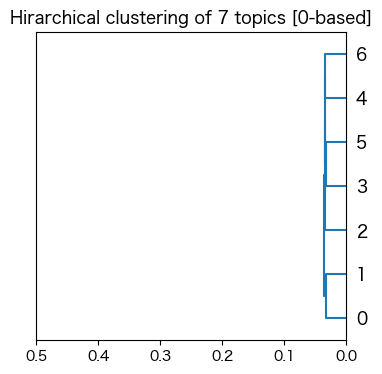

In [2309]:
## D_topic_dist を使った topic の階層クラスタリング
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 作図範囲の指定
plt.figure(figsize = (4, 4))

## 距離行列の生成
top_linkage = linkage(topic_dist, method = 'ward', metric = 'euclidean')
dendrogram(top_linkage, orientation = 'left')

## 作図
plt.xlim(0.5, 0) # 異なる分析に比較を楽にするために，x軸の大きさを固定
plt.title(f"Hirarchical clustering of {n_topics} topics [0-based]")
plt.show()

In [2310]:
## tSNE を使った topic のクラスタリング
import sklearn.manifold

## 必要に応じて reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い
relative = True
if relative:
    #top_perplexity_reduct_rate = 0.5 # 定義は先頭に移動
    top_perplexity_val = round(n_topics * top_perplexity_reduct_rate)
else:
    top_perplexity_val = 5 # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")

## 3D version
top_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = top_perplexity_val, n_iter = 1000)

top_perplexity_val: 4


In [2311]:
## topic_dist データに適用 topic_dist のグループ化 (3D)
topic_tsne_3d = top_tSNE_3d.fit_transform(topic_dist)

In [2312]:
## 必要に応じて Plotly を導入
#!pip3 install -U plotly

In [2313]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 変数の指定
d1, d2, d3 = topic_tsne_3d[:,0], topic_tsne_3d[:,1], topic_tsne_3d[:,2]
fig = go.Figure(data = [go.Scatter3d(x = d1, y = d2, z = d3,
                                     mode = 'markers', marker = dict(size = 7)) ])

## 3D 散布図にラベルを追加する処理は未実装
if use_FastText:
    if use_LDA:
        title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of topics=dims under {term_type}-based LDA x FastText ({n_topics} dims=topics)"
    else:
        title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of dims under FastText ({n_topics} dims=topics)"
else:
    title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of topics {term_type}-based LDA ({n_topics} topics)"
#
fig.update_layout(title = dict(text = title_val),
                  autosize = False, width = 600, height = 600,)
fig.show()

docs のクラスタリング

In [2314]:
## LDA モデルを使ったエンコード
check      = False
lda_encoding = [ ]
print(f"get {term_type}-based LDA encodings for documents")
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc_temp = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc_temp: {enc_temp}")
    lda_encoding.append([ x[-1] for x in enc_temp])
#
len(lda_encoding)
if verbose:
    random.sample(lda_encoding, 2)

get skippy2gram-based LDA encodings for documents


In [2315]:
## FastText を使ったエンコード
from gensim.models import FastText
## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get {term_type}-based FastText encodings for documents")
ft_model = FastText(df[doc_type],
                    vector_size = vector_size_val,
                    window = n_for_ngrams,
                    min_count = 1,
                    sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in df[doc_type] ]
#
len(ft_encoding)
if check:
    random.sample(ft_encoding, 3)

get skippy2gram-based FastText encodings for documents


In [2316]:
## doc_encoding の選択: LDA か FastText か両方の組み合わせか
check = False
if use_LDA:
    if use_FastText:
        doc_encoding = [ x + y for x, y in zip(lda_encoding, ft_encoding) ]
        encoding_method = "LDA x FastText"
    else:  
        doc_encoding = lda_encoding
        encoding_method = "LDA"
else:
    doc_encoding = ft_encoding
    encoding_method = "FastText"
len(doc_encoding)
## sample の確認
if check:
    print(random.sample(doc_encoding, 3))

In [2317]:
## df に enc の列を追加
df['enc'] = doc_encoding
if verbose:
    df

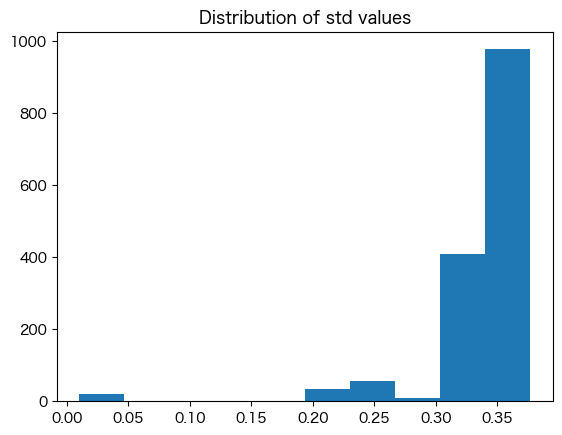

In [2318]:
## エンコーディングのstd の分布を見る
import numpy as np
from matplotlib import pyplot as plt

std_dist = [ np.std(x) for x in df['enc'] ]
plt.hist(std_dist)
plt.title(f"Distribution of std values")
plt.show()
## 0 周辺に事例があるなら，エンコーディング効率が悪い

In [2319]:
## 一様分布の事例を除外
import numpy as np

check = False
print(f"{len(df)} instances before filtering")
enc = df['enc']

max_std = max([ np.std(x) for x in enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in enc])))[-1]
print(f"std 2nd min: {second_min_std}")

1500 instances before filtering
std 1st min: 0.010309339500963688
std 2nd min: 0.3768223822116852


In [2320]:
## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
import numpy as np

std_threshold = second_min_std / 9 # 穏健な値を得るために9で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
classified = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ classified ]
#
print(f"filtering leaves {len(df_filtered)} instances ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.041869153579076133
filtering leaves 1481 instances (19 instances removed)


In [2321]:
## 弱いサンプリング
secondary_sampling = False
if secondary_sampling:
    df = df.sample(round(len(df) * 0.5))
len(df)

1500

In [2322]:
df['domain_id'].value_counts().sort_index()
## 0: 医療用語
## 1: 医療縮約表現
## 2: 経済用語
## 3: 法律用語
## 4: 出版用語
## 5: 調理用語
## 6: その他

domain_id
0    500
3    500
5    500
Name: count, dtype: int64

t-SNE on docs

In [2323]:
## tSNE を使った documents のクラスタリング
import sklearn.manifold

## reload on necessity
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が変わるので，色々な値を試すと良い
relative = True
if relative:
    doc_perplexity_val = round(len(df) * doc_perplexity_reduct_rate)
else:
    doc_perplexity_val = 300 # 大き過ぎると良くない
print(f"doc_perplexity_val: {doc_perplexity_val}")

## 3D version
doc_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = doc_perplexity_val, n_iter = 1000)
## データに適用
E = np.array(list(df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(E)

doc_perplexity_val: 495


tSNE の結果の可視化 (Ploty を使って)

In [2324]:
## 変数
import pandas as pd
fitting = doc_tSNE_3d
plot_df = pd.DataFrame(
    zip(fitting[:,0], fitting[:,1], fitting[:,2], df['domain_id'], df['aberrated'], df[doc_type]),
    columns = ['D1', 'D2', 'D3', 'domain_id', 'aberrated', doc_type])
#
plot_df

,D1,D2,D3,domain_id,aberrated,word
0,0.279223,2.526824,-1.062894,3,0,永住許可
1,0.255574,-0.168467,-3.057266,5,0,天狗の麦飯
2,0.492611,-0.306066,-2.982322,5,0,柿の葉寿司
3,-0.120482,1.674668,2.359297,0,0,応急入院
4,-0.088614,1.674148,2.166528,5,0,弟子屈ラーメン
...,...,...,...,...,...,...
1495,0.056221,1.491893,2.247662,3,0,身元保証金
1496,0.530328,-0.136100,-2.978214,5,0,鮎の石焼き
1497,-0.197240,1.638754,2.209908,0,0,腸炎後症候群
1498,0.246320,2.449835,-0.898528,3,0,被疑者勾留


In [2325]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np
#
domain_ids = set(plot_df['domain_id'])
reverse_domain_list = False
if reverse_domain_list:
    domain_ids = sorted(domain_list, reverse = True)
fig = go.Figure()
for domain_id in domain_ids:
    # set marker size of the target domain
    if domain_id == [ k for k, v in domain_mapping.items() if v == target_domain ][0]:
        size_val = 6
    else:
        size_val = 3
    part = plot_df[ plot_df['domain_id'] == domain_id ]
    color = colormap[domain_id]
    print(f"color: {color}")
    fig.add_trace(
        go.Scatter3d(
            x = part['D1'], y = part['D2'], z = part['D3'],
            name = domain_mapping[domain_id],
            mode = 'markers',
            marker = dict(size = size_val, opacity = 0.8),
            #marker_colorscale = list(colormap.values()),
            marker_color = color,
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
if use_FastText:
    if use_LDA:
        title_val = f"tSNE 3D (ppl: {doc_perplexity_val}) of {term_type}-based LDA x FastText ({n_topics} topics=dims, window size: {window_size})"
    else:
        title_val = f"tSNE 3D (ppl: {doc_perplexity_val}) of FastText ({n_topics} dims, window size: {window_size})"
else:
    title_val = f"tSNE 3D (ppl: {doc_perplexity_val}) of {term_type}-based LDA ({n_topics} topics=dims)"
#
fig.update_layout(title = dict(text = title_val), autosize = False, width = 700, height = 700)
fig.show()

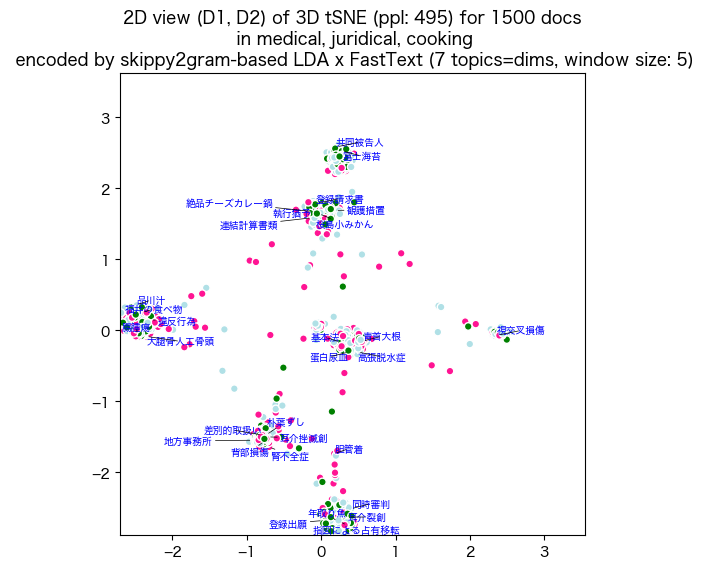

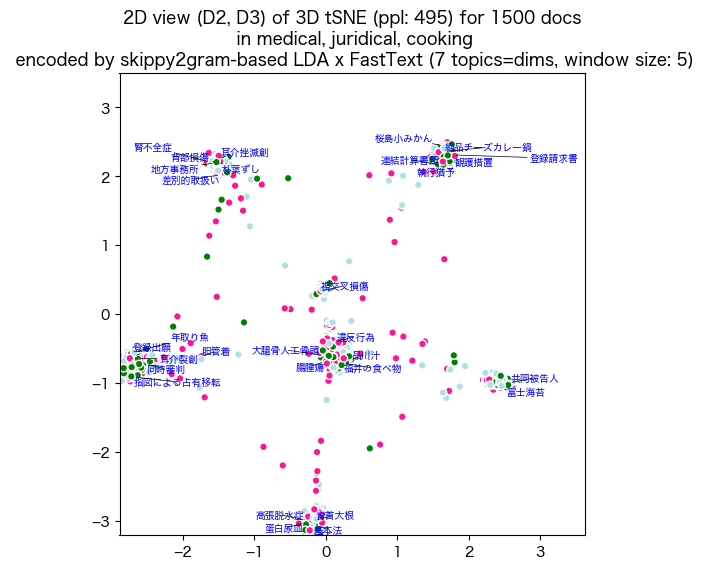

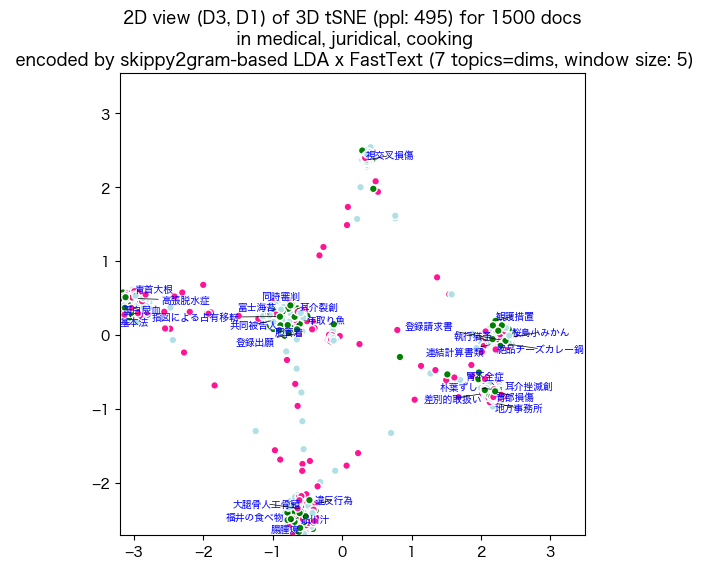

In [2326]:
%%capture --no-display

## tSNE の結果の可視化
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 文字を表示する事例のサンプリング
relative = True
lab_sampling_rate = 0.02 # サンプリング率の指定
if relative:
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定
print(f"lab_sample_n: {lab_sample_n}")

## labels の生成
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]
##
for i in range(3):
    roll = np.roll([0,1,2], -i)
    asp1, asp2 = roll[0], roll[1]
    X, Y = doc_tSNE_3d[:, asp1], doc_tSNE_3d[:, asp2]
    ## 
    plt.figure(figsize = (6, 6))
    plt.xlim(X.min(), X.max() + 1)
    plt.ylim(Y.min(), Y.max() + 1)

    ## 分野ごとの色分け
    cmap = list(map(lambda i: colormap[i], df['domain_id'])) # colormap は最初に定義してある
    scatter = plt.scatter(X, Y, s = 30, c = cmap, edgecolors = 'w')
    ##
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    get_Float_object_is_not_subsriptable_Error = False
    if get_Float_object_is_not_subsriptable_Error:
        pass
    else:
        adjust_text(texts,
                    expand_points = (1, 1), expand_text = (1, 1),
                    force_points = 0.2,
                    force_text = 0.2,
                    arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    if use_FastText:
        if use_LDA:
            title_val = f"2D view (D{asp1+1}, D{asp2+1}) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs\n in {', '.join(selected_domains.keys())}\n encoded by {term_type}-based LDA x FastText ({n_topics} topics=dims, window size: {window_size})"
        else:
            title_val = f"2D view (D{asp1+1}, D{asp2+1}) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs\n in {', '.join(selected_domains.keys())}\n encoded by FastText ({n_topics} dims, window size: {window_size})"

    else:
        title_val = f"2D view (D{asp1+1}, D{asp2+1}) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs\n in {', '.join(selected_domains.keys())}\n encoded by {term_type}-based LDA ({n_topics} topics)"
    #
    plt.title(title_val)
    plt.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: ピンク Pink
## 経済用語:    オレンジ Orange
## 法律用語:    緑 Green
## 出版用語:    明るい緑 Pale Turquoise
## 調理用語:    小麦色 wheat
## その他:      灰色 gray

DBSCAN で docs をクラスタリング

In [2327]:
## DBSCAN でクラスタリング
from sklearn.cluster import DBSCAN

## eps は事例ごとに調節が必要
eps_val = 0.5; min_samples_val = 2
D_clustered = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(doc_tSNE_3d)

## cluster id の取得
cluster_ids = D_clustered.labels_

## クラスターの数を確認: 多過ぎ，少な過ぎの場合は eps_val を調整する
np.unique(cluster_ids)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [2328]:
## 必要に応じて Seaborn を道入
#!pip install -U seaborn

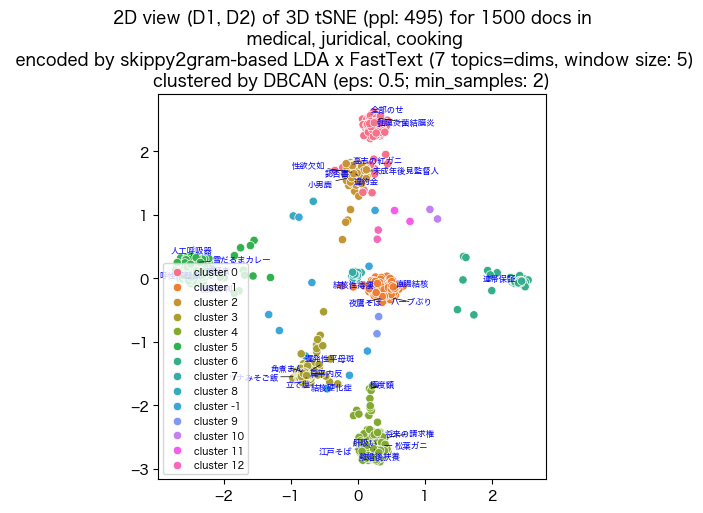

In [2329]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (5, 5))

d1, d2 = doc_tSNE_3d[:,0], doc_tSNE_3d[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in cluster_ids ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.02 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 6, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
title_tail = f"\nclustered by DBCAN (eps: {eps_val}; min_samples: {min_samples_val})"
if use_FastText:
    if use_LDA:
        title_val = f"2D view (D1, D2) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs in\n {', '.join(selected_domains.keys())}\n encoded by {term_type}-based LDA x FastText ({n_topics} topics=dims, window size: {window_size})" + title_tail
    else:
        title_val = f"2D view (D1, D2) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs in\n {', '.join(selected_domains.keys())}\n encoded by FastText ({n_topics} dims, window size: {window_size})" + title_tail

else:
    title_val = f"2D view (D1, D2) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs in\n {', '.join(selected_domains.keys())}\n encoded by {term_type}-based LDA ({n_topics} topics)" + title_tail
#
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

階層クラスタリングのための再サンプリング

In [2330]:
## 階層クラスタリングのための事例サンプリング
hc_sampling_rate = 0.2 # 変更可能: 大きくし過ぎると図が見にくい
df_size = len(df_filtered)
if df_size > 600:
    hc_df_sampled = df_filtered.sample(round(df_size * hc_sampling_rate), replace = False)
else:
    hc_df_sampled = df_filtered
##
print(f"{len(hc_df_sampled)} rows are sampled (preserve rate: {len(hc_df_sampled)/len(df_filtered):0.3f})")

296 rows are sampled (preserve rate: 0.200)


In [2331]:
hc_df_sampled['aberrated'].value_counts

<bound method IndexOpsMixin.value_counts of 299     0
2581    0
1594    0
3243    0
251     0
       ..
1876    0
555     0
453     0
282     0
354     0
Name: aberrated, Length: 296, dtype: int64>

In [2332]:
## HCデータの保存
if save_df_sampled:
    import datetime as dt
    ct = dt.datetime.now()
    ## Pandas で .csv として
    import pandas as pd
    # .csv 
    output_as_csv = f"saves/df_sampled-{ct.date()}-{str(ct.time())[:2]}" + ".csv"
    print(f"saving data to {output_as_csv}")
    hc_df_sampled.to_csv(output_as_csv, encoding = "utf-8")
    # .xlsx
    output_as_xlsx = f"saves/df_sampled-{ct.date()}-{str(ct.time())[:2]}" + ".xlsx"
    print(f"saving data to {output_as_xlsx}")
    hc_df_sampled.to_excel(output_as_xlsx)
    ## pickle.dump(..)で
    output_fn2 = f"saves/df_sampled-{ct.date()}-{str(ct.time())[:2]}" + ".p"
    import pickle
    print(f"saving data to {output_fn2}")
    with open(output_fn2, "wb") as f:
        pickle.dump(hc_df_sampled, f)

In [2333]:
## domain 事例数の確認
hc_df_sampled['domain_id'].value_counts().sort_index()

domain_id
0     98
3    105
5     93
Name: count, dtype: int64

階層クラスタリング

In [2334]:
## Plotly が必要な場合に実行
#!pip install -U plotly

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_41758/3445949097.py:48: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



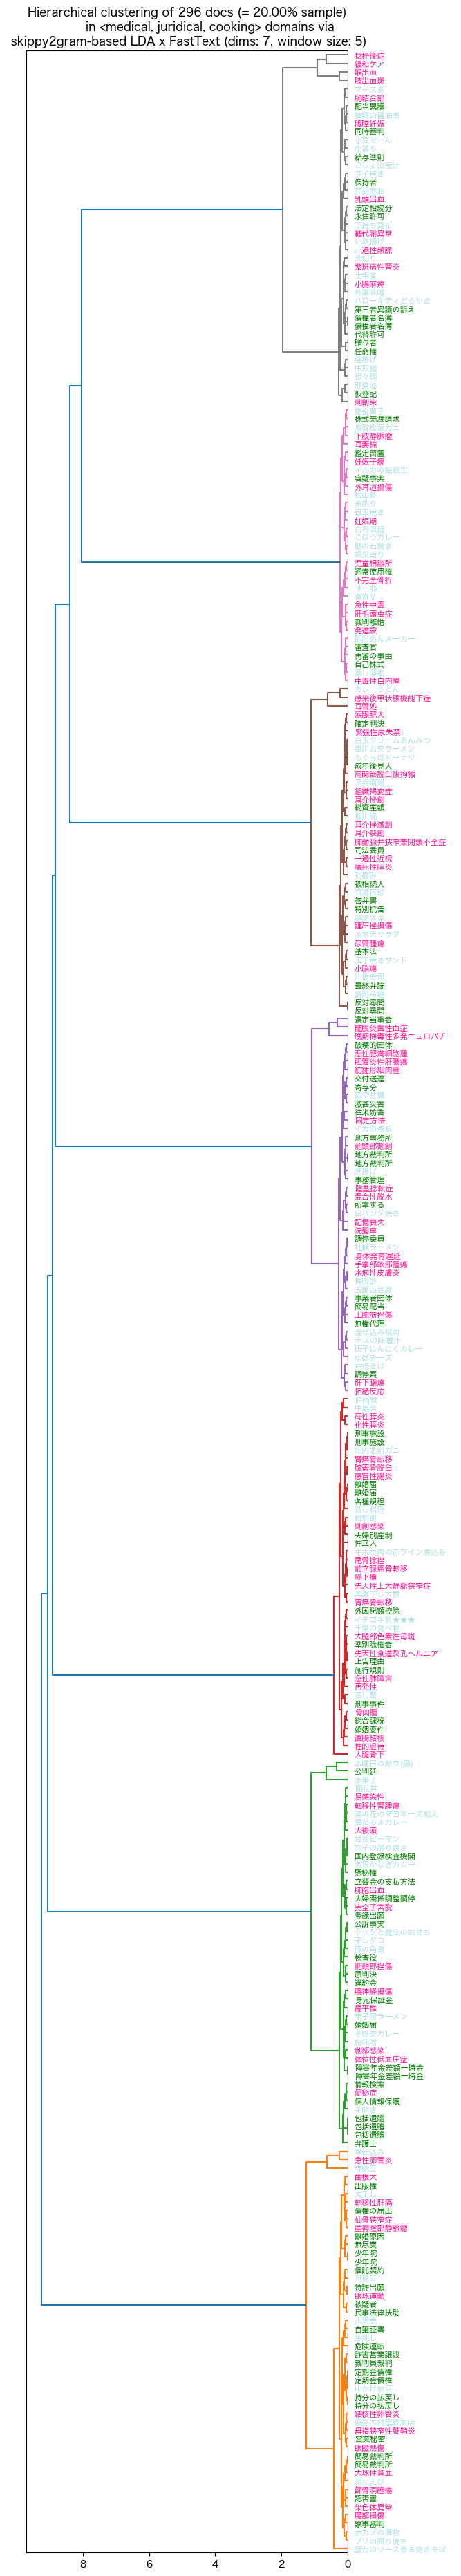

In [2335]:
## doc 階層クラスタリングの実行
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.cluster.hierarchy import dendrogram, linkage

## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定

## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(hc_df_sampled) * 0.016))) # This needs to be run here, before dendrogram construction.

## 距離行列の構築
doc_linkage = linkage(list(hc_df_sampled['enc']), method = 'ward', metric = 'euclidean')
## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(hc_df_sampled[doc_type]) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 題の指定
df_size = len(hc_df_sampled)
sampling_rate = f"{100 * hc_sampling_rate:.2f}"
domain_names = ', '.join(selected_domains.keys())
if use_FastText:
    if use_LDA:
        title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
            in <{domain_names}> domains via\n {term_type}-based {encoding_method} (dims: {n_topics}, window size: {window_size})"
    else:
        title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
            in <{domain_names}> domains via\n {encoding_method} (dims: {n_topics}, window size: {window_size})"
else:
    title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
        in <{domain_names}> domains via\n {term_type}-based {encoding_method} ({n_topics} dims)"
plt.title(title_val)

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    ## filter matched rows
    matched_rows = hc_df_sampled.loc[hc_df_sampled[doc_type] == word]
    if len(matched_rows) == 1:
        row = matched_rows
    else:
        row = matched_rows.iloc[0] # matched_rows[0] fails to work
    ## extract domain_id value
    try:
        domain_id = int(row['domain_id'])
        #ticker.set_color(plotly.colors.qualitative.Plotly[domain_id + 1]) # id の基数調整
        ticker.set_color(colormap[domain_id]) # id の基数調整
    except TypeError:
        pass
#
plt.show()
## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: 赤 Pink
## 経済用語:    オレンジ Orange
## 法律用語:    緑 Green
## 出版用語:    明るい緑 Pale Turquoise
## 調理用語:    小麦色 PowderBlue
## その他:      灰色 gray

In [2336]:
## aberrated の混ざったdoc 階層クラスタリングの実行
aberrations = hc_df_sampled[hc_df_sampled['aberrated'] == 1][doc_type]
print(aberrations)

111        感染後甲状腺機能下症
2286              小脳瘍
1510             恥結合部
2471              発達段
3394             肢出血斑
1119             化性膵炎
409           髄膜炎菌性血症
2399              歯根大
3399             大腿骨下
3413             捻挫後症
2137              刺創染
2204              喉出血
44      晩期梅毒性多発ニュロパチー
1853             局性膵炎
630            紡錘形細肉腫
2577              耳管処
Name: word, dtype: object


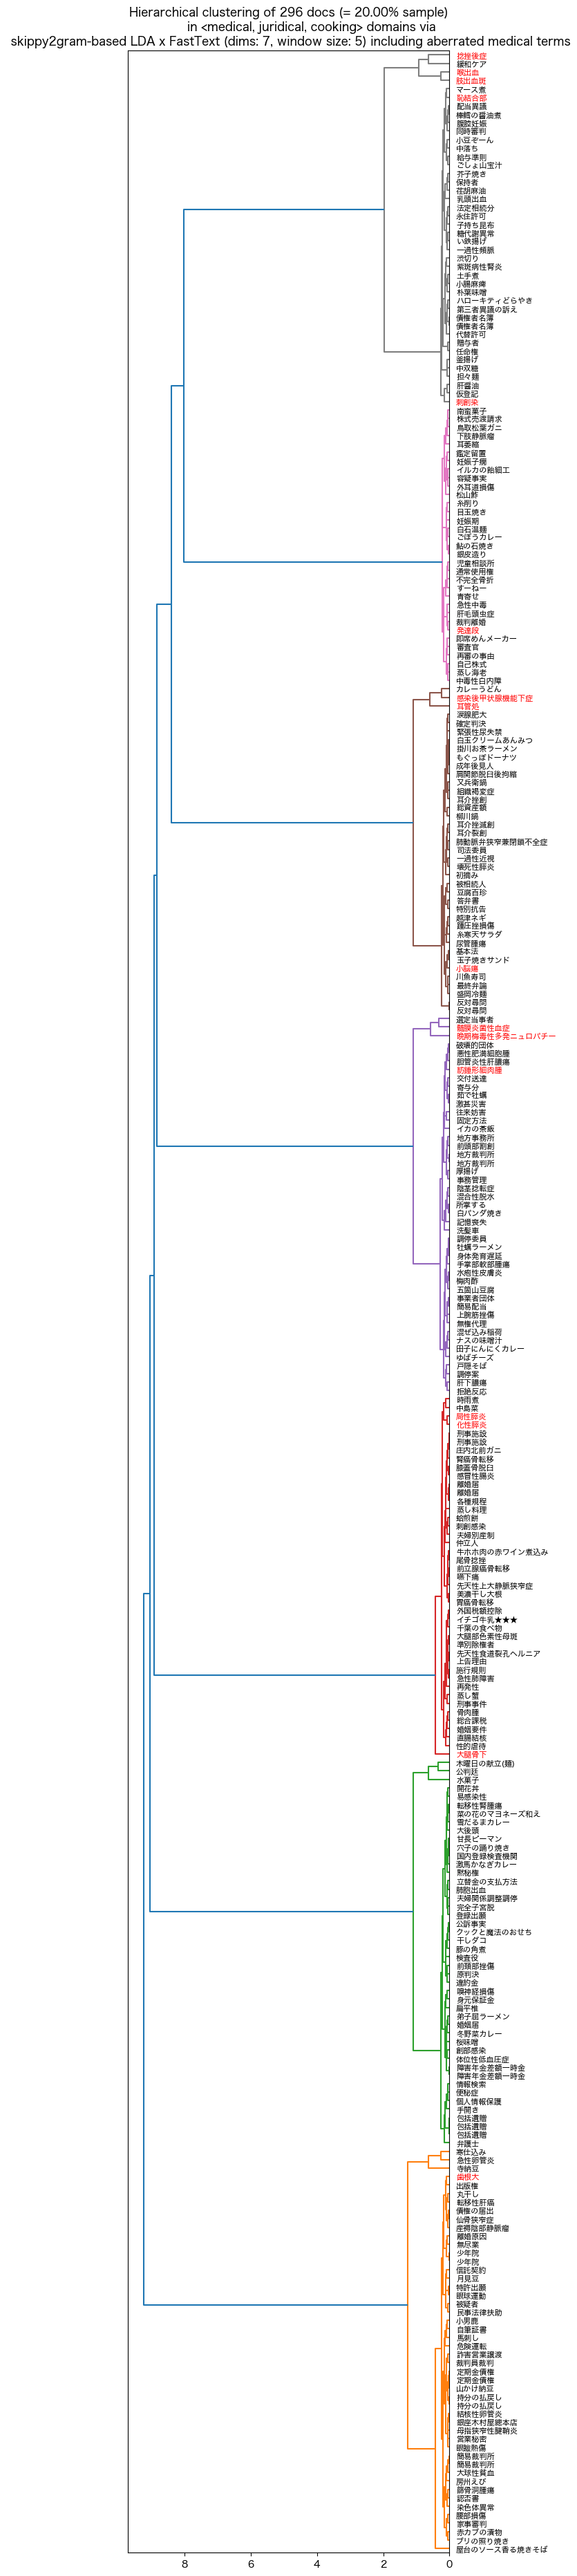

In [2337]:
if len(aberrations) == 0:
    exit(0)

##
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.cluster.hierarchy import dendrogram, linkage

## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定

## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(hc_df_sampled) * 0.016))) # This needs to be run here, before dendrogram construction.

## 距離行列の構築
doc_linkage = linkage(list(hc_df_sampled['enc']), method = 'ward', metric = 'euclidean')
## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(hc_df_sampled[doc_type]) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 題の指定
df_size = len(hc_df_sampled)
sampling_rate = f"{100 * hc_sampling_rate:.2f}"
domain_names = ', '.join(selected_domains.keys())
title_tail = f" including aberrated medical terms"
if use_FastText:
    if use_LDA:
        title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
            in <{domain_names}> domains via\n {term_type}-based {encoding_method} (dims: {n_topics}, window size: {window_size})" + title_tail
    else:
        title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
            in <{domain_names}> domains via\n {encoding_method} (dims: {n_topics}, window size: {window_size})" + title_tail
else:
    title_val = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample)\n\
        in <{domain_names}> domains via\n {term_type}-based {encoding_method} ({n_topics} dims)" + title_tail
plt.title(title_val)

## aberrated == 1 の事例を色分けする
ax = plt.gca()
check = False
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    if check:
        print(f"word: {word}")
    if word in set(aberrations):
        if check:
            print(f"aberrated word:{word}")
        ticker.set_color('red')
#
plt.show()